# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

Video N°155: Importing a script full of helper functions (and saving lots of space)

## Creating helper functions

In previous notebooks, we 've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here:

```python
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
```
> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper functions.

In [1]:
import tensorflow as tf
import os
import random
import zipfile

# Import helper functions we're going to use in this notebook
from MachineLearningUtils.training_utilities.model_callbacks import create_tensorboard_callback
from MachineLearningUtils.data_visualization.model_learning_curves import plot_loss_curves
from MachineLearningUtils.data_visualization.image_visualization import walk_through_dir, display_random_images_from_class
from MachineLearningUtils.data_acquisition.data_downloader import download_data, extract_archive_file

2024-04-07 21:43:09.164107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Video N°156: Downloading and turning our images into a TensorFlow BatchDataset

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [2]:
# Get 10% of training data of 10 classes of Food101
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
download_data(url=url,file_path="10_food_classes_10_percent.zip", extract=True)

The file 10_food_classes_10_percent.zip already exists.
Extracting 10_food_classes_10_percent.zip as ZIP...
10_food_classes_10_percent.zip has been extracted to current directory.


In [3]:
# Check out how many images and subdirectories are in dataset
walk_through_dir(dir_path="10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [4]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
# Args for image_dataset_from_directory
idfd_args={
    "image_size":(224, 224),
    "label_mode":"categorical",
    "batch_size":32
}

In [6]:
import tensorflow as tf
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            **idfd_args)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


2024-04-07 21:43:12.578298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-07 21:43:12.578336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: wm18vw2023
2024-04-07 21:43:12.578345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: wm18vw2023
2024-04-07 21:43:12.578539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 545.23.8
2024-04-07 21:43:12.578568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 545.23.8
2024-04-07 21:43:12.578577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 545.23.8
2024-04-07 21:43:12.578891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network

In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[3.30000000e+01 3.30000000e+01 3.30000000e+01]
   [3.33316345e+01 3.14744892e+01 3.24030609e+01]
   [3.40000000e+01 3.20000000e+01 3.50000000e+01]
   ...
   [3.68571205e+01 3.08571205e+01 3.08571205e+01]
   [3.07142334e+01 2.47142334e+01 2.47142334e+01]
   [2.35152588e+01 1.78724365e+01 1.68009033e+01]]

  [[3.20714264e+01 3.20714264e+01 3.20714264e+01]
   [3.29285736e+01 3.10714283e+01 3.20000000e+01]
   [3.40000000e+01 3.20000000e+01 3.50000000e+01]
   ...
   [3.93417969e+01 3.33417969e+01 3.33417969e+01]
   [3.37091446e+01 2.77091446e+01 2.77091446e+01]
   [2.58111229e+01 2.01683006e+01 1.90967674e+01]]

  [[3.07857132e+01 3.07857132e+01 3.07857132e+01]
   [3.19285717e+01 3.00714283e+01 3.10000000e+01]
   [3.42142868e+01 3.22142868e+01 3.52142868e+01]
   ...
   [4.14285278e+01 3.54285278e+01 3.54285278e+01]
   [3.82856903e+01 3.22856903e+01 3.22856903e+01]
   [2.99998608e+01 2.43570385e+01 2.32855053e+01]]

  ...

  [[2.55000000e+02 2.55000000e+02 2.55000000e+02]
   [2

Video N°157: Discussing the four (actually five) modelling experiments we're running
Video N°158: Comparing the TensorFlow Keras Sequential API versus the Functional API
N°159: Note: Fixes for EfficientNetB0 model creation + weight loading
**Old:**
```python
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
```
**New:**
```python
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
```
Video N°160: Creating our first model with the TensorFlow Keras Functional API

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


Video N°161: Compiling and fitting our first Functional API model

In [11]:
# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240407-214315
Epoch 1/5
24/24 [==============================] - 24s 833ms/step - loss: 1.8593 - accuracy: 0.4227 - val_loss: 1.2948 - val_accuracy: 0.7500
Epoch 2/5
24/24 [==============================] - 19s 809ms/step - loss: 1.1501 - accuracy: 0.7453 - val_loss: 0.9003 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 18s 752ms/step - loss: 0.8391 - accuracy: 0.8093 - val_loss: 0.7059 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 17s 730ms/step - loss: 0.6895 - accuracy: 0.8440 - val_loss: 0.6362 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 18s 744ms/step - loss: 0.5948 - accuracy: 0.8680 - val_loss: 0.5749 - val_accuracy: 0.8569


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 33s 417ms/step - loss: 0.5632 - accuracy: 0.8608


[0.5632346272468567, 0.86080002784729]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


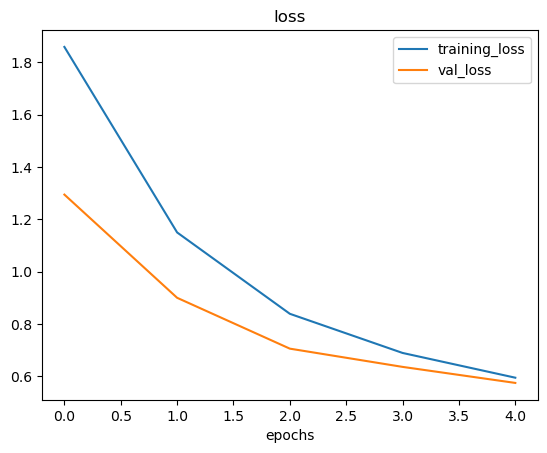

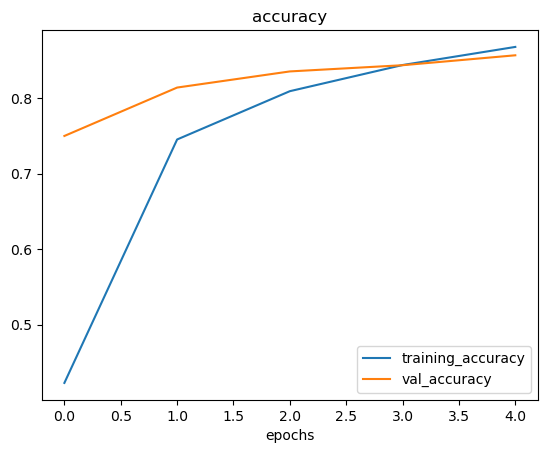

In [16]:
# Check out our model's training curves
plot_loss_curves(history=history_10_percent)

Video N°162: Getting a feature vector from our trained model

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePoolin2D.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor=input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> 🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the leatned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then used to extract patterns out of for our own specific problem. 

Video N°163: Drilling into the concept of a feature vector (a learned representation)
Video N°164: Downloading and preparing the data for Model 1(1 percent of training data) 

## Running a series of transfer learning experiments

We've seen the incredible  results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... How about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same tests dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [19]:
# Download and unzip data - preprocessed from Food101
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
download_data(url=url, file_path="10_food_classes_1_percent.zip", extract=True)

The file 10_food_classes_1_percent.zip already exists.
Extracting 10_food_classes_1_percent.zip as ZIP...
10_food_classes_1_percent.zip has been extracted to current directory.


In [20]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with?
walk_through_dir(dir_path="10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [22]:
# Check previously saved arguments
idfd_args

{'image_size': (224, 224), 'label_mode': 'categorical', 'batch_size': 32}

In [23]:
# Setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           **idfd_args)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Video N°165: Building a data augmentation layer to use inside our model

## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing of doing this within the TensorFlow Data augmentation documentation:
https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenation them) happens on the GPU (much faster) rather than the CPU.
* Image data augmenation only happens during training, so we can still export our whole model and use it elsewhere.

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmenation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

N°166: Note: Small fix for next video, for images not augmenting
**Old:**
```python
augmented_img = data_augmentation(img)
```
**New:**
```python
augmented_img = data_augmentation(img, training=True)
```

Video N°167: Visualizing what happens when images pass through our data augmentation layer

### Visualize our data augmentation layer (and see what happens to our data)

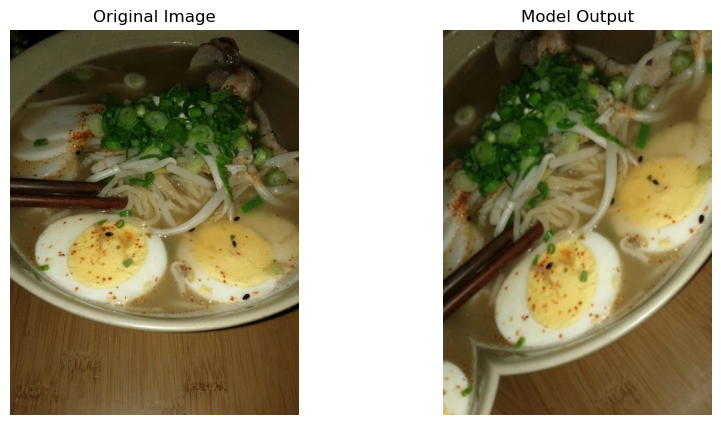

In [25]:
# View a random image and compare it to its augmented version
from pathlib import Path
import random
from MachineLearningUtils.data_visualization.augmentation_effects import apply_model_and_compare
base_dir = Path("10_food_classes_1_percent/train")
target_class = random.choice(train_data_1_percent.class_names)
target_dir = base_dir / target_class
random_image_path = random.choice(list(target_dir.glob('*')))
apply_model_and_compare(img_path=random_image_path,
                        model=data_augmentation)

Video N°168: Building Model 1 (with a data augmentation layer and 1% of training data)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# Make a model using the input and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240407-214531
Epoch 1/5
3/3 [==============================] - 16s 5s/step - loss: 2.4446 - accuracy: 0.1000 - val_loss: 2.1239 - val_accuracy: 0.2319
Epoch 2/5
3/3 [==============================] - 9s 4s/step - loss: 2.1817 - accuracy: 0.2143 - val_loss: 2.0283 - val_accuracy: 0.3306
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 2.0265 - accuracy: 0.3143 - val_loss: 1.9379 - val_accuracy: 0.3898
Epoch 4/5
3/3 [==============================] - 9s 4s/step - loss: 1.8896 - accuracy: 0.4857 - val_loss: 1.8399 - val_accuracy: 0.4638
Epoch 5/5
3/3 [==============================] - 9s 4s/step - loss: 1.7363 - accuracy: 0.5857 - val_loss: 1.7857 - val_accuracy: 0.4753


In [27]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [28]:
# Evaluate on the full test dataset
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 33s 412ms/step - loss: 1.7794 - accuracy: 0.4900


[1.7793705463409424, 0.49000000953674316]

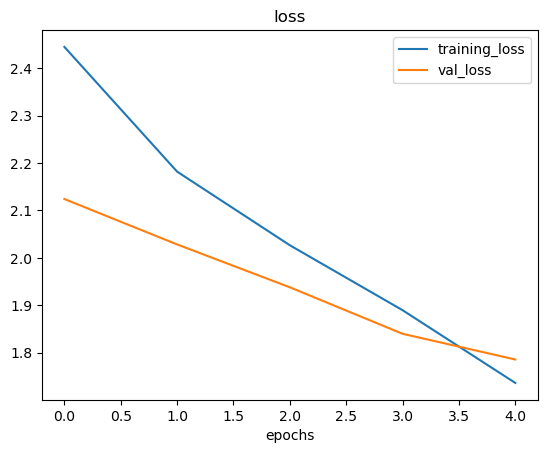

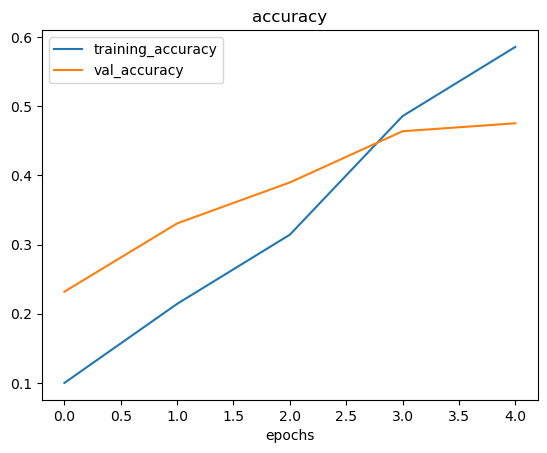

In [29]:
# How do the model with 1% of the training data and data augmentation loss curves look?
plot_loss_curves(history=history_1_percent)

Video N°169: Building Model 2 (with a data augmentation layer and 10% of training data)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [30]:
# Get 10% of data
url ="https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
download_data(url=url, file_path="10_food_classes_10_percent.zip", extract=True)

The file 10_food_classes_10_percent.zip already exists.
Extracting 10_food_classes_10_percent.zip as ZIP...
10_food_classes_10_percent.zip has been extracted to current directory.


In [31]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [32]:
# How many images are in our directories?
walk_through_dir(dir_path="10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [33]:
# Set data inputs
print("idfd_args:",idfd_args)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            **idfd_args)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args)

idfd_args: {'image_size': (224, 224), 'label_mode': 'categorical', 'batch_size': 32}
Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# Create model 2 with data augmentation built in
from tensorflow.keras.models import Sequential
# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255.) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

Video N°170: Creating a ModelCheckpoint to save our model's weights during training

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [36]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

Video N°171: Fitting and evaluating Model 2 (and saving its weights using ModelCheckpoint)

### Fit model 2 passing in the ModelCheckpoint callbacks

In [37]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240407-214700
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0755 - accuracy: 0.3133
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 30s 998ms/step - loss: 2.0755 - accuracy: 0.3133 - val_loss: 1.5139 - val_accuracy: 0.6513
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4127 - accuracy: 0.6493
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 893ms/step - loss: 1.4127 - accuracy: 0.6493 - val_loss: 1.0889 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.7307
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 869ms/step - loss: 1.1023 - accuracy: 0.7307 - val_loss: 0.8759 - val_accuracy: 0.7730
E

In [38]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 30s 380ms/step - loss: 0.5632 - accuracy: 0.8608


[0.5632346868515015, 0.86080002784729]

In [39]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 33s 421ms/step - loss: 0.6649 - accuracy: 0.8208


[0.6649414300918579, 0.8208000063896179]

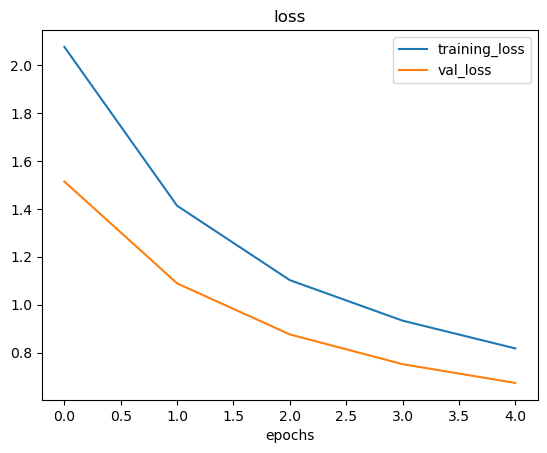

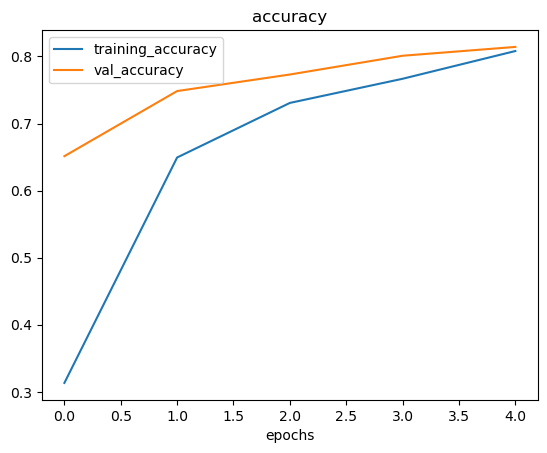

In [40]:
# Plot model loss curves
plot_loss_curves(history=history_10_percent_data_aug)

Video N°172: Loading and comparing saved weights to our existing trained Model 2

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [41]:
# Load in saved model weights and evaluate model
model_2.load_weights(filepath=checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 31s 389ms/step - loss: 0.6649 - accuracy: 0.8208


In [43]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
results_10_percent_data_aug

[0.6649414300918579, 0.8208000063896179]

In [45]:
loaded_weights_model_results

[0.6649414896965027, 0.8208000063896179]

In [46]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [47]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


Video N°173: Preparing Model 3 (our first fine-tuned model)

## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [48]:
# Layers in loaded model
model_2.layers

In [49]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f17dd50ecd0> True
<keras.engine.sequential.Sequential object at 0x7f18230fc1f0> True
<keras.engine.functional.Functional object at 0x7f17dd4fd550> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f18231b4310> True
<keras.layers.core.dense.Dense object at 0x7f17dd322a60> True


In [50]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i+1, layer.name, layer.trainable)

1 input_3 False
2 rescaling_2 False
3 normalization_2 False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_project_conv False
8 block1a_project_bn False
9 block1a_project_activation False
10 block2a_expand_conv False
11 block2a_expand_bn False
12 block2a_expand_activation False
13 block2a_project_conv False
14 block2a_project_bn False
15 block2b_expand_conv False
16 block2b_expand_bn False
17 block2b_expand_activation False
18 block2b_project_conv False
19 block2b_project_bn False
20 block2b_drop False
21 block2b_add False
22 block3a_expand_conv False
23 block3a_expand_bn False
24 block3a_expand_activation False
25 block3a_project_conv False
26 block3a_project_bn False
27 block3b_expand_conv False
28 block3b_expand_bn False
29 block3b_expand_activation False
30 block3b_project_conv False
31 block3b_project_bn False
32 block3b_drop False
33 block3b_add False
34 block4a_expand_conv False
35 block4a_expand_bn False
36 block4a_expand_activation False
37 block4a_dwconv2

In [51]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [52]:
from MachineLearningUtils.training_utilities.transfer_learning import configure_trainable_layers 

In [53]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
configure_trainable_layers(model=base_model, n_trainable_layers=10, verbose=True)

Layer 1: input_3, Trainable: False
Layer 2: rescaling_2, Trainable: False
Layer 3: normalization_2, Trainable: False
Layer 4: stem_conv, Trainable: False
Layer 5: stem_bn, Trainable: False
Layer 6: stem_activation, Trainable: False
Layer 7: block1a_project_conv, Trainable: False
Layer 8: block1a_project_bn, Trainable: False
Layer 9: block1a_project_activation, Trainable: False
Layer 10: block2a_expand_conv, Trainable: False
Layer 11: block2a_expand_bn, Trainable: False
Layer 12: block2a_expand_activation, Trainable: False
Layer 13: block2a_project_conv, Trainable: False
Layer 14: block2a_project_bn, Trainable: False
Layer 15: block2b_expand_conv, Trainable: False
Layer 16: block2b_expand_bn, Trainable: False
Layer 17: block2b_expand_activation, Trainable: False
Layer 18: block2b_project_conv, Trainable: False
Layer 19: block2b_project_bn, Trainable: False
Layer 20: block2b_drop, Trainable: False
Layer 21: block2b_add, Trainable: False
Layer 22: block3a_expand_conv, Trainable: False
Lay

In [54]:
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=['accuracy'])


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the ULMFiT paper:

In [55]:
# Check which layers are tunable (trainable)
for i, layer in enumerate(model_2.layers[2].layers):
    print(i+1, layer.name, layer.trainable)

1 input_3 False
2 rescaling_2 False
3 normalization_2 False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_project_conv False
8 block1a_project_bn False
9 block1a_project_activation False
10 block2a_expand_conv False
11 block2a_expand_bn False
12 block2a_expand_activation False
13 block2a_project_conv False
14 block2a_project_bn False
15 block2b_expand_conv False
16 block2b_expand_bn False
17 block2b_expand_activation False
18 block2b_project_conv False
19 block2b_project_bn False
20 block2b_drop False
21 block2b_add False
22 block3a_expand_conv False
23 block3a_expand_bn False
24 block3a_expand_activation False
25 block3a_project_conv False
26 block3a_project_bn False
27 block3b_expand_conv False
28 block3b_expand_bn False
29 block3b_expand_activation False
30 block3b_project_conv False
31 block3b_project_bn False
32 block3b_drop False
33 block3b_add False
34 block4a_expand_conv False
35 block4a_expand_bn False
36 block4a_expand_activation False
37 block4a_dwconv2

In [56]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [57]:
model_2.trainable_variables

[<tf.Variable 'block6h_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.00207604,  0.01300672,  0.02047416, ..., -0.02240255,
           -0.07708141, -0.00094655],
          [-0.06357138,  0.0959678 , -0.05430871, ..., -0.01352078,
           -0.05987524, -0.11093444],
          [ 0.0068749 , -0.04681807, -0.01513974, ...,  0.03073284,
           -0.01280731,  0.03616464],
          ...,
          [ 0.11381665,  0.00804447, -0.05432149, ...,  0.08015257,
           -0.06561387, -0.05522665],
          [-0.12468243,  0.06938899, -0.07634895, ...,  0.01121222,
           -0.0128268 ,  0.10406019],
          [-0.04722364,  0.10557885,  0.16247186, ...,  0.04582691,
            0.01228108, -0.04941604]]]], dtype=float32)>,
 <tf.Variable 'block6h_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.04594925,  2.5461788 , -1.426646  , -0.7885664 , -0.24730209,
        -0.5630991 , -0.6161863 , -0.4029834 , -1.4444699 , -1.0481553 ,
        -0.21704195,

Video N°174: Fitting and evaluating Model 3 (our first fine-tuned model)

In [58]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5
print(fine_tune_epochs)

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

10
Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240407-215040
Epoch 5/10
24/24 [==============================] - 26s 839ms/step - loss: 0.7024 - accuracy: 0.8093 - val_loss: 0.5485 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 19s 799ms/step - loss: 0.5870 - accuracy: 0.8267 - val_loss: 0.5075 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 19s 824ms/step - loss: 0.5067 - accuracy: 0.8507 - val_loss: 0.4887 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 19s 817ms/step - loss: 0.5139 - accuracy: 0.8333 - val_loss: 0.4776 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 19s 797ms/step - loss: 0.4825 - accuracy: 0.8440 - val_loss: 0.4447 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 20s 854ms/step - loss: 0.4281 - accuracy: 0.8667 - val_loss: 0.4682 - val_accuracy: 0.8487


In [59]:
# Evaluate the fine-tuned model (model_3 wich is actualy model_2 fine-tuned for another 5 epochs)
result_fine_tune_10_percent = model_2.evaluate(test_data)
result_fine_tune_10_percent

79/79 [==============================] - 30s 378ms/step - loss: 0.4682 - accuracy: 0.8420


[0.46821630001068115, 0.8420000076293945]

In [60]:
results_10_percent_data_aug

[0.6649414300918579, 0.8208000063896179]

Video N°175: Comparing our model's results before and after fine-tuning

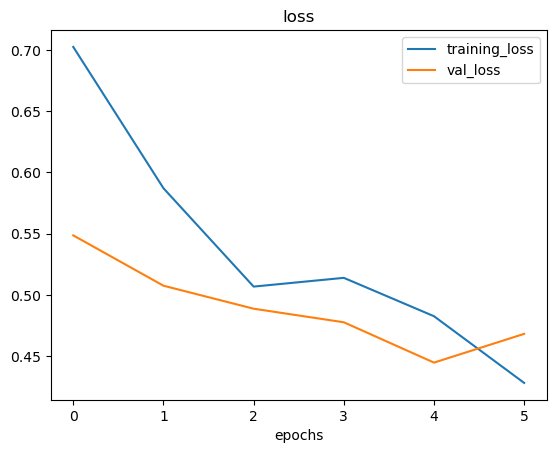

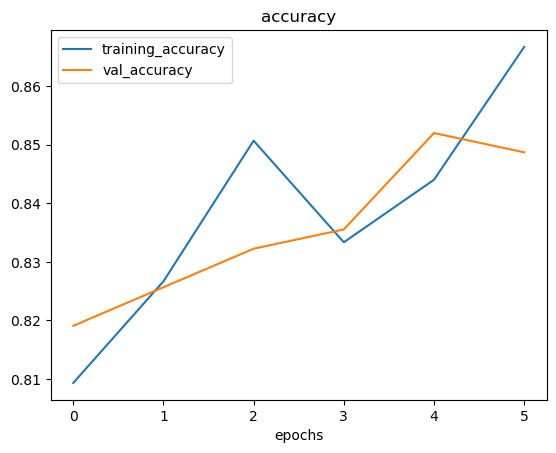

In [61]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history=history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [62]:
from MachineLearningUtils.data_visualization.model_learning_curves import compare_histories

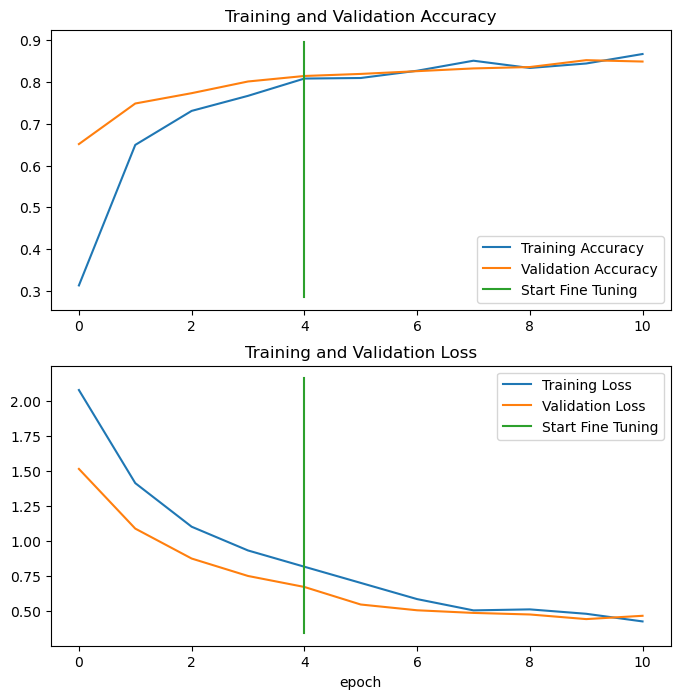

In [63]:
# Let's create a function to compare training histories
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_percent_data_aug,
                  initial_epochs=5)

Video N°176: Downloading and preparing data for our biggest experiment yet (Model 4)

## Model 4: Fine-tuning and existing model on all of the data